In [1]:
list_of_packages <- c("ggplot2", "dplyr", "tidyr", "circlize", "patchwork")
for (package in list_of_packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                package,
                character.only = TRUE,
                quietly = TRUE,
                
                warn.conflicts = FALSE
            )
        )
    )
}
    

In [2]:
figures_path <- file.path("../figures/NF0014/")
# Get the current working directory and find Git root
find_git_root <- function() {
    # Get current working directory
    cwd <- getwd()

    # Check if current directory has .git
    if (dir.exists(file.path(cwd, ".git"))) {
        return(cwd)
    }

    # If not, search parent directories
    current_path <- cwd
    while (dirname(current_path) != current_path) {  # While not at root
        parent_path <- dirname(current_path)
        if (dir.exists(file.path(parent_path, ".git"))) {
            return(parent_path)
        }
        current_path <- parent_path
    }

    # If no Git root found, stop with error
    stop("No Git root directory found.")
}

# Find the Git root directory
root_dir <- find_git_root()
cat("Git root directory:", root_dir, "\n")


Git root directory: /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline 


In [3]:
figures_path <- file.path(root_dir,"5.EDA/figures/linear_modeling/")
if (!dir.exists(figures_path)) {
    dir.create(figures_path, recursive = TRUE)
}

In [4]:
organoid_fs_lm_results_path <- file.path(
    root_dir,
    "5.EDA/results/linear_modeling/organoid_fs.parquet"
)
organoid_fs_lm_results_df <- arrow::read_parquet(
    organoid_fs_lm_results_path
)
head(organoid_fs_lm_results_df)

patient,treatment,feature,rsquared,rsquared_adj,fvalue,pvalue,coefficient,intercept,Feature_type,Compartment,Channel,Measurement,Extra_info
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
NF0014,Mirdametinib,AreaSizeShape_Organoid_VOLUME,0.003306290,-0.040028219,0.07629693,0.7848467,0.2031591,3.021073e-16,AreaSizeShape,Organoid,NA,VOLUME,NA
NF0014,Mirdametinib,AreaSizeShape_Organoid_EXTENT,0.042792042,0.001174305,1.02821645,0.3211270,-0.4681452,2.387247e-16,AreaSizeShape,Organoid,NA,EXTENT,NA
NF0014,Mirdametinib,AreaSizeShape_Organoid_EULERNUMBER,0.011774489,-0.031191838,0.27403992,0.6056422,0.2933569,6.435937e-18,AreaSizeShape,Organoid,NA,EULERNUMBER,NA
NF0014,Mirdametinib,AreaSizeShape_Organoid_EQUIVALENTDIAMETER,0.004533666,-0.038747479,0.10474921,0.7491277,-0.1962333,-4.067154e-16,AreaSizeShape,Organoid,NA,EQUIVALENTDIAMETER,NA
NF0014,Mirdametinib,AreaSizeShape_Organoid_SURFACEAREA,0.023323746,-0.019140439,0.54925689,0.4661216,0.4594321,1.211966e-16,AreaSizeShape,Organoid,NA,SURFACEAREA,NA
NF0014,Mirdametinib,Colocalization_Organoid_AGPER_MEDIANCORRELATIONCOEFF,0.039526180,-0.002233551,0.94651423,0.3407297,0.4052390,-5.067875e-16,Colocalization,Organoid,AGPER,MEDIANCORRELATIONCOEFF,NA


Warning message:
“Removed 378 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 378 rows containing missing values or values outside the scale range
(`geom_point()`).”


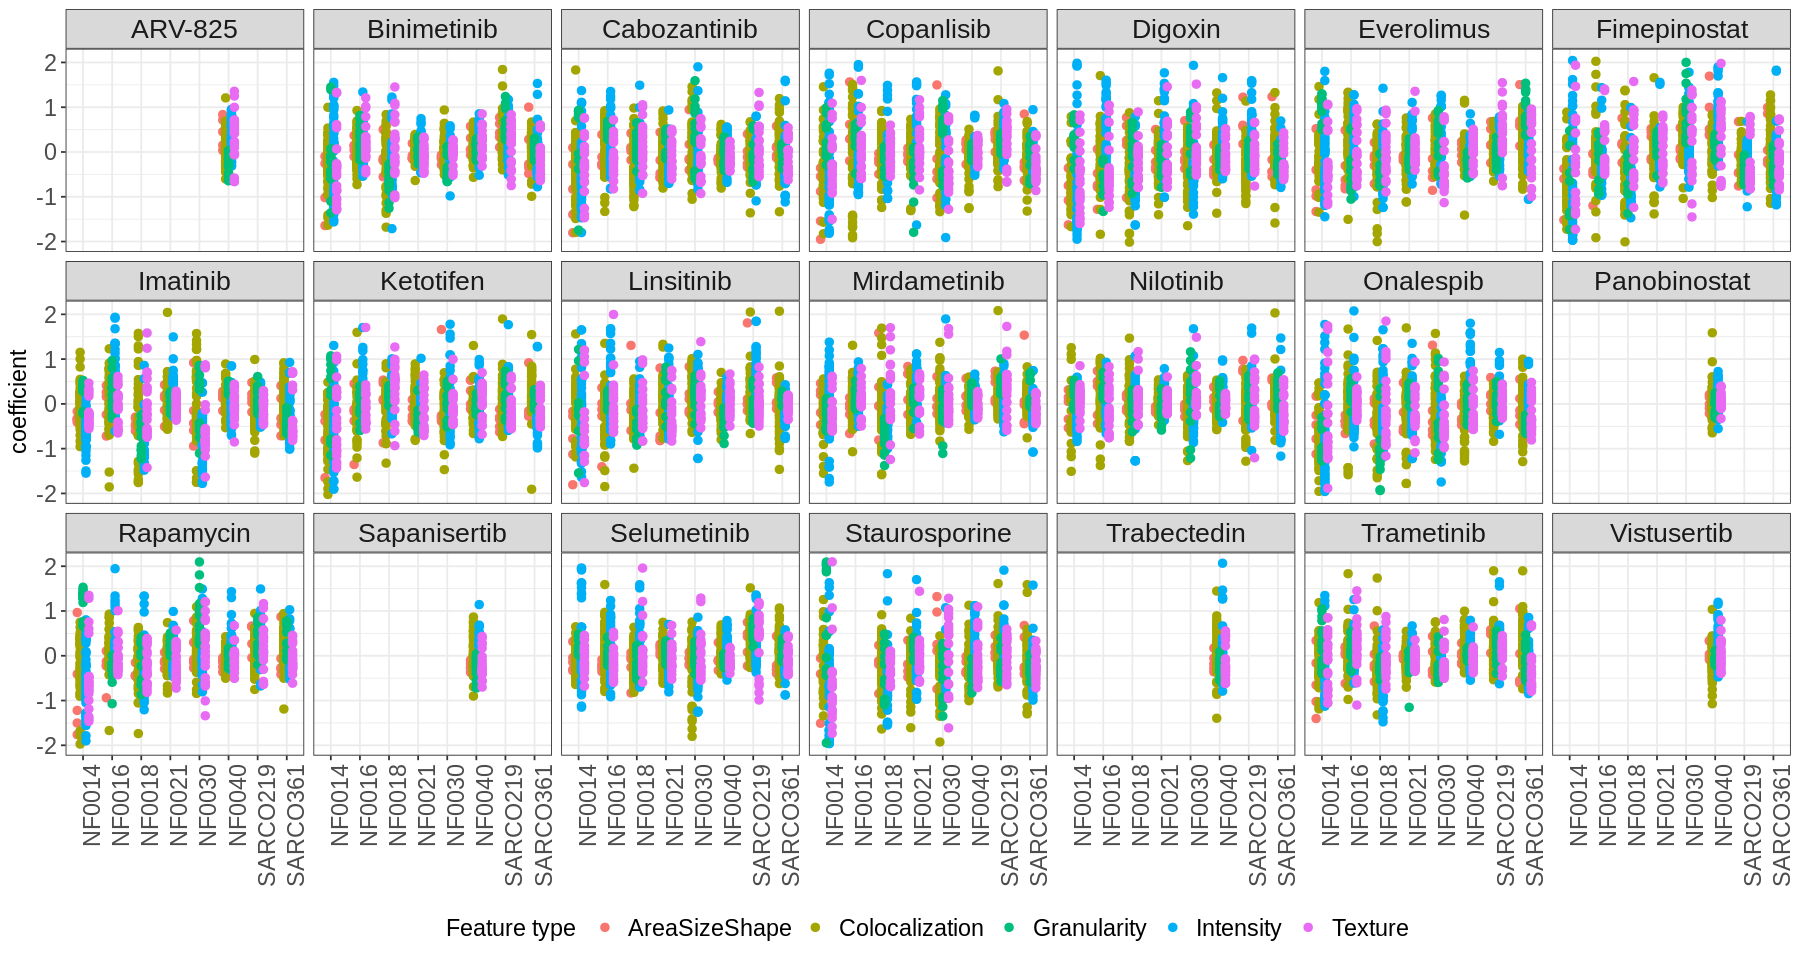

In [5]:
width <- 15
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
coeff_plot <- (
    ggplot(organoid_fs_lm_results_df,
        aes(x = patient , y = coefficient, color = Feature_type))
    + geom_point(
        position = position_dodge(width = 0.5),
        size = 2
    )
    + theme_bw()
    + ylim(
        quantile(organoid_fs_lm_results_df$coefficient, 0.01),
        quantile(organoid_fs_lm_results_df$coefficient, 0.99)
        )
    + facet_wrap( ~ treatment, ncol = 7)
    + theme(
        axis.text.x = element_text(angle = 90, hjust = 1, size = 14),
        legend.position = "bottom",
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 14),
        axis.title.y = element_text(size = 14),
        strip.text = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14)
        
    )
    + guides(
        color = guide_legend(nrow = 1, title = "Feature type"),    )

)
ggsave(
    filename = file.path(figures_path, "organoid_linear_modeling_results_all_patients.png"),
    plot = coeff_plot,
    width = width,
    height = height
)
coeff_plot

In [6]:
patients <- unique(organoid_fs_lm_results_df$patient)
for (patient_id in patients) {
    patient_file_path <- file.path(
            figures_path,
            patient_id
        )
        if (!dir.exists(patient_file_path)) {
            dir.create(patient_file_path, recursive = TRUE)
        }
    organoid_fs_lm_results_df_patient <- organoid_fs_lm_results_df %>%
        filter(patient == patient_id)
    width <- 14
    height <- 14
    options(repr.plot.width = width, repr.plot.height = height)
    plot <- (
        ggplot(organoid_fs_lm_results_df_patient,
            aes(x = Feature_type, y = coefficient, fill = Feature_type))
        + geom_boxplot(
            position = position_dodge(width = 0.5),
            size = 0.1,
        )
        + theme_bw()
        + labs(
            x = "Feature type",
            y = "Coefficient",
            title = paste("Linear modeling results for", patient_id)
        )
        + ylim(
                quantile(organoid_fs_lm_results_df_patient$coefficient, 0.01),
                quantile(organoid_fs_lm_results_df_patient$coefficient, 0.99)
                )
        + facet_wrap( ~ treatment, scales = "free_y", ncol = 4)
        + theme(
            axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 14),
            axis.text.y = element_text(size = 14),
            axis.title.x = element_text(size = 14),
            axis.title.y = element_text(size = 14),
            plot.title = element_text(size = 14, hjust = 0.5),
            legend.text = element_text(size = 14),
            legend.title = element_text(size = 14),
            legend.position = "bottom",
            strip.text = element_text(size = 14)
        )
        + guides(
            fill = guide_legend(title = "")
        )
    )
    ggsave(
        filename = file.path(patient_file_path, paste0("organoid_linear_modeling_results_", patient_id, ".png")),
        plot = plot,
        width = width,
        height = height
    )
}

Warning message:
“Removed 46 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 44 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 46 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 46 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 46 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 62 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 46 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 46 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


## Single cell plots

In [7]:
sc_fs_lm_results_path <- file.path(
    root_dir,
    "5.EDA/results/linear_modeling/sc_fs.parquet"
)
sc_fs_lm_results_df <- arrow::read_parquet(
    sc_fs_lm_results_path
)
head(sc_fs_lm_results_df)

patient,treatment,feature,rsquared,rsquared_adj,fvalue,pvalue,coefficient,intercept,Feature_type,Compartment,Channel,Measurement,Extra_info
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
NF0014,Mirdametinib,AreaSizeShape_Nuclei_EXTENT,0.0004514536,-0.001596802,0.2204089,6.389383e-01,-0.04717608,-4.076600e-17,AreaSizeShape,Nuclei,NA,EXTENT,NA
NF0014,Mirdametinib,AreaSizeShape_Nuclei_EQUIVALENTDIAMETER,0.0298346808,0.027846637,15.0070549,1.217212e-04,-0.40875830,-2.836273e-16,AreaSizeShape,Nuclei,NA,EQUIVALENTDIAMETER,NA
NF0014,Mirdametinib,AreaSizeShape_Nuclei_SURFACEAREA,0.0007826988,-0.001264878,0.3822562,5.366867e-01,-0.06181901,-2.471981e-17,AreaSizeShape,Nuclei,NA,SURFACEAREA,NA
NF0014,Mirdametinib,Colocalization_Nuclei_AGPER_MEANCORRELATIONCOEFF,0.0310297013,0.029044106,15.6274080,8.853526e-05,0.40030170,-3.469447e-17,Colocalization,Nuclei,AGPER,MEANCORRELATIONCOEFF,NA
NF0014,Mirdametinib,Colocalization_Nuclei_AGPER_MINMANDERSCOEFFM1,0.0048852658,0.002846096,2.3957134,1.223165e-01,0.13765366,-1.633893e-16,Colocalization,Nuclei,AGPER,MINMANDERSCOEFFM1,NA
NF0014,Mirdametinib,Colocalization_Nuclei_AGPER_MEANMANDERSCOEFFM2,0.0053524522,0.003314240,2.6260525,1.057687e-01,-0.22826856,9.715536e-16,Colocalization,Nuclei,AGPER,MEANMANDERSCOEFFM2,NA


In [8]:
# drop the NA in Compartment
sc_fs_lm_results_df <- sc_fs_lm_results_df %>%
    filter(!is.na(Compartment))


In [9]:
# make the compartments a factor
sc_fs_lm_results_df$Compartment <- factor(
    sc_fs_lm_results_df$Compartment,
    levels = c("Nuclei", "Cytoplasm", "Cell")
)

Warning message:
“Removed 918 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 918 rows containing missing values or values outside the scale range
(`geom_point()`).”


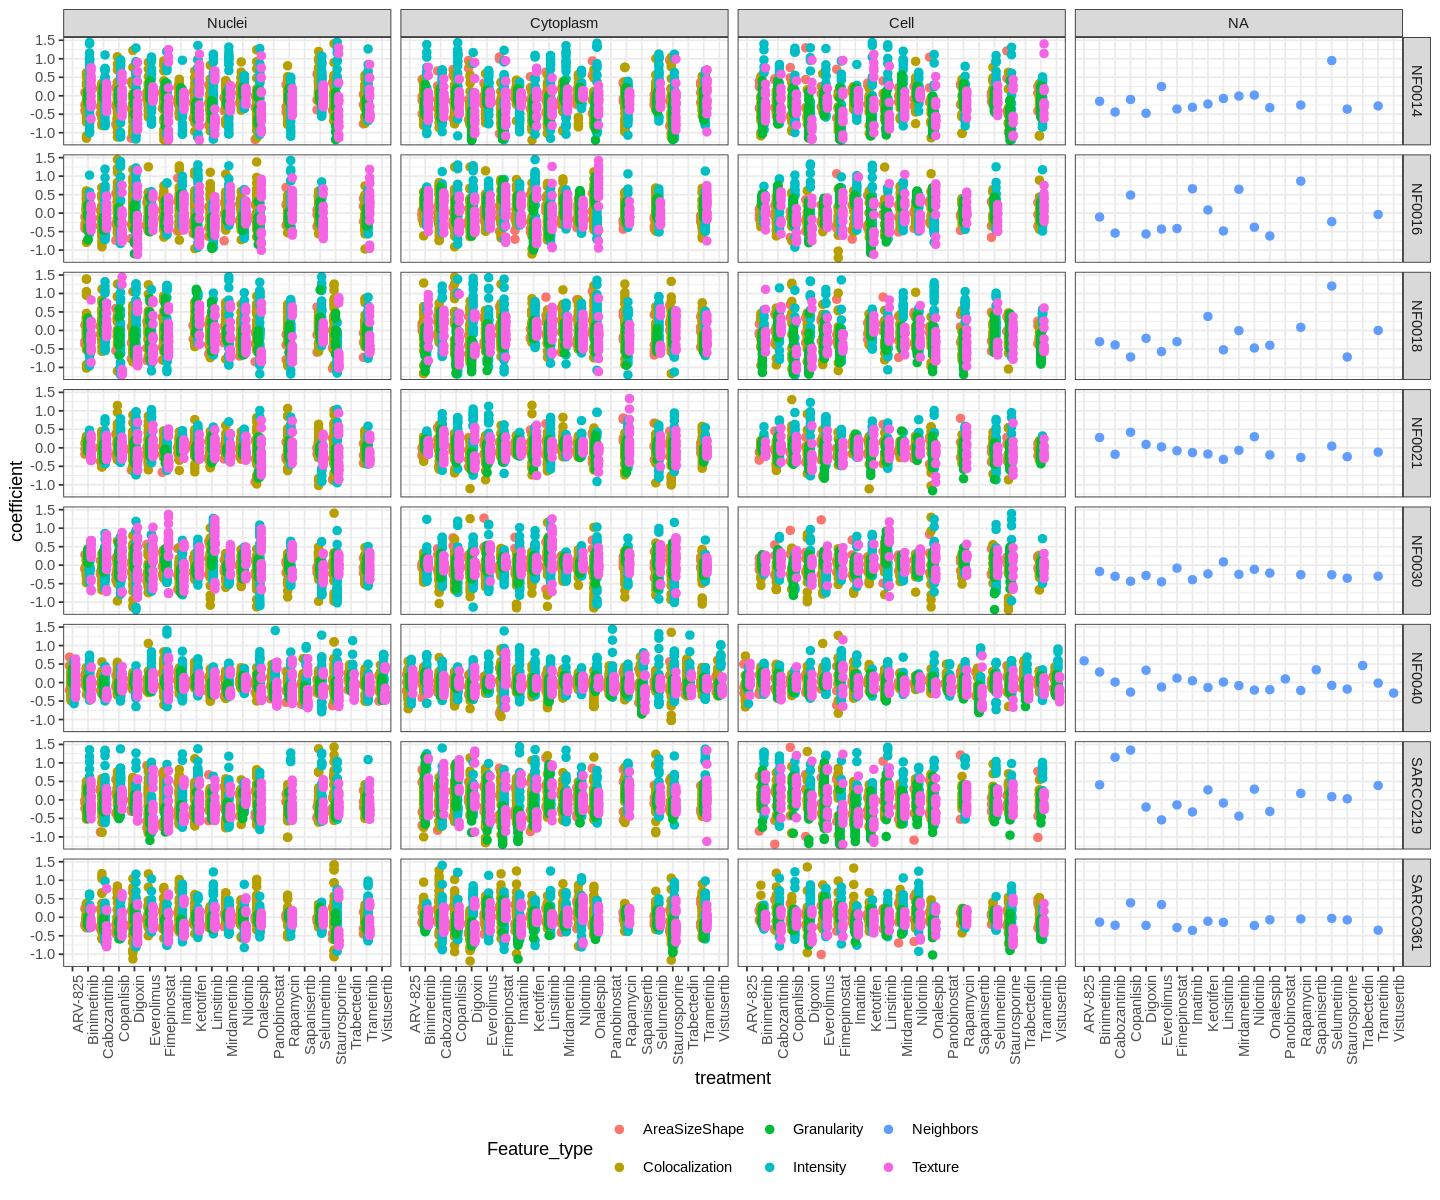

In [10]:
width <- 12
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
coeff_plot <- (
    ggplot(sc_fs_lm_results_df,
        aes(x = treatment , y = coefficient, color = Feature_type))
    + geom_point(
        position = position_dodge(width = 0.5),
        size = 2
    )
    + theme_bw()
    + ylim(
        quantile(sc_fs_lm_results_df$coefficient, 0.01),
        quantile(sc_fs_lm_results_df$coefficient, 0.99)
        )
    + facet_grid(patient ~ Compartment)
    + theme(
        axis.text.x = element_text(angle = 90, hjust = 1),
        legend.position = "bottom"
    )

)
ggsave(
    filename = file.path(figures_path, "sc_linear_modeling_results_all_patients.png"),
    plot = coeff_plot,
    width = width,
    height = height
)
coeff_plot

In [11]:
patients <- unique(sc_fs_lm_results_df$patient)
for (patient_id in patients) {
    sc_fs_lm_results_df_patient <- sc_fs_lm_results_df %>%
        filter(patient == patient_id)
    # create a directory for the patient
    patient_file_path <- file.path(
            figures_path,
            patient_id
        )
        if (!dir.exists(patient_file_path)) {
            dir.create(patient_file_path, recursive = TRUE)
        }
    treatments <- unique(sc_fs_lm_results_df_patient$treatment)
    for (treatment_id in treatments) {
        sc_fs_lm_results_df_patient_drug <- sc_fs_lm_results_df_patient %>%
            filter(treatment == treatment_id)
        # isolate the Colocalization feature type
        sc_fs_lm_results_df_patient_drug_coloc <- sc_fs_lm_results_df_patient_drug %>%
            filter(Feature_type == "Colocalization")
        sc_fs_lm_results_df_patient_drug_all_other <- sc_fs_lm_results_df_patient_drug %>%
            filter(Feature_type != "Colocalization")
        
        width <- 10
        height <- 10
        options(repr.plot.width = width, repr.plot.height = height)
        no_coloc_plot <- (
            ggplot(sc_fs_lm_results_df_patient_drug_all_other,
                aes(x = Channel, y = coefficient, fill = Channel))
            + geom_boxplot(
                position = position_dodge(width = 0.5),
                size = 0.1,
            )
            + theme_bw()
            + labs(
                x = "Feature type",
                y = "Coefficient",
                title = paste0(
                    "Linear modeling results for ", patient_id, " and ", treatment_id)
            )
            + ylim(
                quantile(sc_fs_lm_results_df_patient_drug_all_other$coefficient, 0.01),
                quantile(sc_fs_lm_results_df_patient_drug_all_other$coefficient, 0.99)
                )
            + facet_grid(Feature_type ~ Compartment)
            + theme(
                axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 14),
                axis.text.y = element_text(size = 14),
                axis.title.x = element_text(size = 14),
                axis.title.y = element_text(size = 14),
                plot.title = element_text(size = 14, hjust = 0.5),
                legend.text = element_text(size = 14),
                legend.title = element_text(size = 14),
                legend.position = "none",
                strip.text = element_text(size = 14),
            )
            + guides(
                fill = guide_legend(title = "")
            )
            
        )
        width <- 10
        height <- 4
        options(repr.plot.width = width, repr.plot.height = height)
        coloc_plot <- (
            ggplot(sc_fs_lm_results_df_patient_drug_coloc,
                aes(x = Channel, y = coefficient, fill = Channel))
            + geom_boxplot(
                position = position_dodge(width = 0.5),
                size = 0.1,
            )
            + theme_bw()
            + labs(
                x = "Feature type",
                y = "Coefficient",
                title = paste0(
                    "Linear modeling results for ", patient_id, " and ", treatment_id)
            )
            + ylim(
                quantile(sc_fs_lm_results_df_patient_drug_coloc$coefficient, 0.01),
                quantile(sc_fs_lm_results_df_patient_drug_coloc$coefficient, 0.99)
            )
            + facet_grid(Feature_type ~ Compartment)
            + theme(
                axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 14),
                axis.text.y = element_text(size = 14),
                axis.title.x = element_text(size = 14),
                axis.title.y = element_text(size = 14),
                plot.title = element_text(size = 14, hjust = 0.5),
                legend.text = element_text(size = 14),
                legend.title = element_text(size = 14),
                legend.position = "none",
                strip.text = element_text(size = 14),
            )
            + guides(
                fill = guide_legend(title = "")
            )
            
        )
        height <- 10
        width <- 10
        options(repr.plot.width = width, repr.plot.height = height)

        layout <- "
            AA
            AA
            AA
            BB
        "
        plot <- (
            no_coloc_plot + coloc_plot
            + plot_layout(design = layout)
        )
        
        
    
        ggsave(
            filename = file.path(
                patient_file_path,
                paste0(
                    "sc_linear_modeling_results_", 
                    patient_id,
                    "_",
                    treatment_id,
                    ".png"
                )
            ),
            plot = plot,
            width = width,
            height = height
        )
    }
}


Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
